In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import FittingWorkCleaner as FWC
import Neutrino_Work as NW
from classy import Class

In [2]:
data_1= np.load("mass-300-life-0.030.npz", allow_pickle=True)
f_actual = data_1['fe'][-1]
e_actual = data_1['e'][-1]
Neff_short = data_1['neff']

data_2= np.load("mass-300-life-0.584.npz", allow_pickle=True)
f_actual_2 = data_2['fe'][-1]
e_actual_2 = data_2['e'][-1]
Neff_long = data_2['neff']


data_file = np.load("test-fit.npz", allow_pickle=True)
e = data_file['eps']
f = data_file['fe']


data_file2 = np.load("test-fit2.npz", allow_pickle=True)
e2 = data_file2['eps']
f2 = data_file2['fe']

In [3]:
alpha = 2 
T,N,coeff = FWC.finale(e_actual_2,f_actual_2,4,False)
A,B,C,D,E = coeff[0],coeff[1],coeff[2],coeff[3],coeff[4]
af = data_2['scalefactors'][-1]
tf = data_2['temp'][-1]
T_ncdm = (1/(af*tf))
k = len(e_actual_2)-15
e_shorter = np.delete(e_actual_2,np.s_[-k:])



k_prime = len(e_actual_2)-30
e_prime = np.delete(e_actual_2,np.s_[-k_prime:])
T_prime = T/alpha
N_prime = N
A_prime = A*(alpha)**4
B_prime = B*(alpha)**3
C_prime = C*(alpha)**2
D_prime = D*(alpha)**1
E_prime = E
T_ncdm_p = T_ncdm*alpha

In [4]:
def mimic(e,T,N,A,B,C,D,E,T_ncdm):
    dn = np.zeros(len(e))
    for i in range(len(e)):
        dn[i] = (T_ncdm)**3*(2/((2*np.pi)**3))*((N/(np.exp(e[i]/T)+1))+np.exp(A*(e[i]**4)+B*(e[i]**3)+C*(e[i]**2)+D*e[i]+E))*4*((np.pi)**2)*(e[i]**2)
    return dn 

    
    

In [5]:
mimic(e_shorter,T,N,A,B,C,D,E,T_ncdm)

array([0.        , 0.00217338, 0.00669215, 0.01119693, 0.0143855 ,
       0.01588831, 0.01591205, 0.01489465, 0.01328313, 0.01143328,
       0.0095872 , 0.00788779, 0.00640454, 0.00515839, 0.00414126])

In [6]:
mimic(e_prime,T_prime,N_prime,A_prime,B_prime,C_prime,D_prime,E_prime,T_ncdm_p)

array([0.        , 0.0133843 , 0.02877099, 0.03182411, 0.02656626,
       0.0191744 , 0.01280909, 0.00828252, 0.00538968, 0.0036689 ,
       0.0027006 , 0.00218149, 0.00191558, 0.00178472, 0.00172123,
       0.00168793, 0.00166529, 0.00164363, 0.00161855, 0.00158846,
       0.00155313, 0.00151304, 0.0014689 , 0.00142152, 0.0013717 ,
       0.00132016, 0.00126756, 0.00121445, 0.00116132, 0.00110857])

In [7]:
def larger_emax(filename,alpha_num):
    alpha = alpha_num
    
    data_actual = np.load(filename, allow_pickle=True)
    f = data_actual['fe'][-1]
    e = data_actual['e'][-1]
    
    af = data_actual['scalefactors'][-1]
    tf = data_actual['temp'][-1]
    value = 1/(af*tf) 
    
    T,N,coefficients = FWC.finale(e,f,4,False)
    A,B,C,D,E = coefficients[0],coefficients[1],coefficients[2],coefficients[3],coefficients[4]
    
    T_p = T/alpha
    N_p = N
    A_p = A*(alpha)**4
    B_p = B*(alpha)**3
    C_p = C*(alpha)**2
    D_p = D*(alpha)**1
    E_p = E
    value_p = value*alpha
    
    k = len(e)-15
    e_shorter = np.delete(e,np.s_[-k:])
    dn = mimic(e_shorter,T,N,A,B,C,D,E,value)
    
    
    k_p = len(e)-30
    e_p = np.delete(e,np.s_[-k_p:])
    dn_p = mimic(e_p,T_p,N_p,A_p,B_p,C_p,D_p,E_p,value_p)
    
    
    plt.figure()
    plt.plot(e_shorter,dn,color="blue")
    plt.plot(e_p,dn_p,color='red')
    plt.show
    
    
    plt.figure()
    plt.plot(alpha*e_p,dn_p,color='black')
    plt.show
    
    

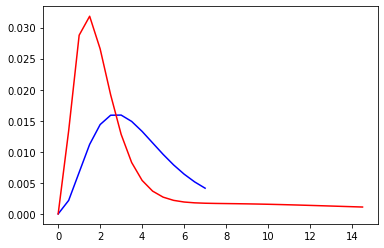

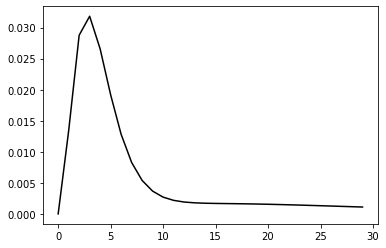

In [8]:
larger_emax("mass-300-life-0.584.npz",2)

In [9]:
actual_data= np.load("mass-300-life-0.030.npz", allow_pickle=True)
af = actual_data['scalefactors'][-1]
tf = actual_data['temp'][-1]
value = (1/(af*tf))
print(value)

0.606538950727753


In [10]:
def v_masses_nontherm_alpha(m_small, normal,filename,plot,file,Pk_graphs):
    
    #if normal is True, uses the normal hiearachy, If normal False, uses the inverted hiearachy.
    #if plot is true, neutrino spectra is plotted. If false, spectra is not plotted. parameters returned in both 
    #if Pk_plots is true, then the matter power spectra plots are plotted. 
    
    actual_data= np.load(filename, allow_pickle=True)
    f_array = actual_data['fe'][-1]
    e_array = actual_data['e'][-1]
    alpha = 1
    poly_degree = 4
    
    mass1,mass2,mass3 = NW.v_masses(m_small,normal)
    
    T_best,N_best,coefficients = FWC.finale(e_array,f_array,poly_degree,plot)
    
    if coefficients[0]>0:
        A = 0 
        
    else:
        A = coefficients[0]
    
    params = '{},{},{},{},{},{},{}'.format(T_best/alpha,N_best,A*alpha**4,coefficients[1]*alpha**3,coefficients[2]*alpha**2,coefficients[3]*alpha,coefficients[4])
    
    af = actual_data['scalefactors'][-1]
    tf = actual_data['temp'][-1]
    value = (1/(af*tf))*alpha

    
    neutrino_mass_settings = {'N_ncdm':3,
          'use_ncdm_psd_files': "0,0,0",
          'm_ncdm': '{},{},{}'.format(mass1,mass2,mass3),
          'T_ncdm':'{},{},{}'.format(value,value,value),
          'ncdm_psd_parameters': params,
          'N_ur': 0.0
          }   
    
    LambdaCDM_settings = {'omega_b':0.0223828,
                     #'omega_cdm':0.1201075,
                     'h':0.67810,
                     'A_s':2.100549e-09,
                     'n_s':0.9660499,
                     'tau_reio':0.05430842,
                     'output':'mPk',
                     'P_k_max_1/Mpc':3.0,
                      'Omega_m':0.309883043,
                     # The next line should be uncommented for higher precision (but significantly slower running)
                     'ncdm_fluid_approximation':3,
                     # You may uncomment this line to get more info on the ncdm sector from Class:
                     'background_verbose':1,
                    }

    neutrino = Class()
    neutrino.set(LambdaCDM_settings)
    neutrino.set(neutrino_mass_settings)
    neutrino.compute()

    neutrino_results = NW.dict_results(neutrino)
    N_eff = neutrino_results['Neff']   
        
    LambdaCDM_other = {'N_ur':'{},{},{}'.format(N_eff,N_eff,N_eff) #needed to get LambdaCDM Neff closer to model Neff
                     }
    
    LambdaCDM = Class()
    LambdaCDM.set(LambdaCDM_settings)
    LambdaCDM.set(LambdaCDM_other)
    LambdaCDM.compute()
    
    LambdaCDM_results = NW.dict_results(LambdaCDM)
    
    kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_LambdaCDM = np.zeros(len(kk)) # P(k) in (Mpc/h)**3
    h = LambdaCDM_settings['h'] # get reduced Hubble for conversions to 1/Mpc

    for i,k in enumerate(kk):
        Pk_LambdaCDM[i] = LambdaCDM.pk(k*h,0.)*h**3 # function .pk(k,z)

    
    kk= np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_neutrino = np.zeros(len(kk))

    for i,k in enumerate(kk):
        Pk_neutrino[i] = neutrino.pk(k*h,0.)*h**3 # function .pk(k,z)
        
        
    np.savez(file, n_results = neutrino_results, L_results = LambdaCDM_results, k_n_array = kk, Pk_n_array = Pk_neutrino, LambdaCDM_array = Pk_LambdaCDM, truth_value = normal, v1 = mass1, v2 = mass2, v3 = mass3, small_mass = m_small, sum_n = mass1+mass2+mass3, alpha_value = alpha)

        
    if Pk_graphs:
        plt.figure()
        plt.loglog(kk,Pk_LambdaCDM)
        plt.loglog(kk,Pk_neutrino,linestyle='--')
        plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
        plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
        plt.show()


        plt.figure()
        plt.semilogx(kk,Pk_neutrino/Pk_LambdaCDM-1)
        plt.xlabel(r'$k [h /\mathrm{Mpc}]$')
        plt.ylabel(r'$P(k)^\nu/P(k)-1$')
        plt.show()
        
        return neutrino_results,LambdaCDM_results
    
    else: 
        return neutrino_results,LambdaCDM_results
        

    
    
   
    

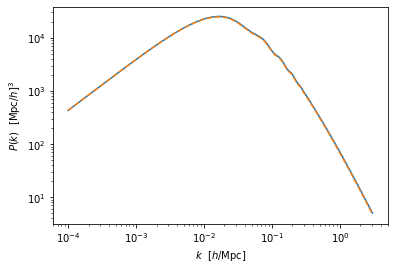

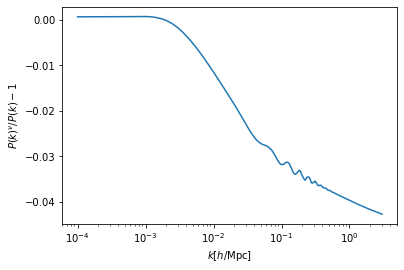

({'age': 13.771976023813258,
  'Neff': 3.0095756649721483,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.2598414844150295,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.30987536538719895,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900631754903148,
  'Omega_m': 0.30987536538719895,
  'Omega_r': 6.145912248617269e-05,
  'rs_drag': 147.40637580060178,
  'Sigma8': 0.8135462595496337,
  'Sigma8_cb': 0.8169815488784717,
  'T_cmb': 2.7255,
  'theta_s_100': 1.043754111062179,
  'theta_star_100': 1.04611419277761,
  'n_s': 0.9660499,
  'tau_reio': 0.05430842},
 {'age': 13.770623072670812,
  'Neff': 3.0095756649721492,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.26120569320189113,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.30988304299999997,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.69002641600826,
  'Omega_m': 0.30988304299999997,
  'Omega_r': 9.054099174000942e-05,
  'rs_d

In [11]:
v_masses_nontherm_alpha(0.001,True,"mass-300-life-0.030.npz",False,"test2_dontkeep",True)

In [12]:
def v_masses_therm(m_small, normal,saved_file,power_graphs):
    
    #if normal is True, uses the normal hiearachy, If normal False, uses the inverted hiearachy.
    
    mass1,mass2,mass3 = NW.v_masses(m_small,normal)
    
    T,N,A,B,C,D,E = 1,1,0,0,0,0,-100
    
    params = '{},{},{},{},{},{},{}'.format(T,N,A,B,C,D,E)
    
    
    neutrino_mass_settings = {'N_ncdm':3,
          'use_ncdm_psd_files': "0,0,0",
          'm_ncdm': '{},{},{}'.format(mass1,mass2,mass3),
          'T_ncdm': "0.71,0.71,0.71",
          'ncdm_psd_parameters': params,
          'N_ur': 0.0
          }   
    
    LambdaCDM_settings = {'omega_b':0.0223828,
                     #'omega_cdm':0.1201075,
                     'h':0.67810,
                     'A_s':2.100549e-09,
                     'n_s':0.9660499,
                     'tau_reio':0.05430842,
                     'output':'mPk',
                     'P_k_max_1/Mpc':3.0,
                      'Omega_m':0.309883043,
                     # The next line should be uncommented for higher precision (but significantly slower running)
                     'ncdm_fluid_approximation':3,
                     # You may uncomment this line to get more info on the ncdm sector from Class:
                     'background_verbose':1,
                    }

    neutrino = Class()
    neutrino.set(LambdaCDM_settings)
    neutrino.set(neutrino_mass_settings)
    neutrino.compute()

    neutrino_results = NW.dict_results(neutrino)
    N_eff = neutrino_results['Neff']   
        
    LambdaCDM_other = {'N_ur':'{},{},{}'.format(N_eff,N_eff,N_eff) #needed to get LambdaCDM Neff closer to model Neff
                     }
    
    LambdaCDM = Class()
    LambdaCDM.set(LambdaCDM_settings)
    LambdaCDM.set(LambdaCDM_other)
    LambdaCDM.compute()
    
    LambdaCDM_results = NW.dict_results(LambdaCDM)
    
    kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_LambdaCDM = np.zeros(len(kk)) # P(k) in (Mpc/h)**3
    h = LambdaCDM_settings['h'] # get reduced Hubble for conversions to 1/Mpc

    for i,k in enumerate(kk):
        Pk_LambdaCDM[i] = LambdaCDM.pk(k*h,0.)*h**3 # function .pk(k,z)

    
    kk= np.logspace(-4,np.log10(3),1000) # k in h/Mpc
    Pk_neutrino = np.zeros(len(kk))

    for i,k in enumerate(kk):
        Pk_neutrino[i] = neutrino.pk(k*h,0.)*h**3 # function .pk(k,z)
        
        
    np.savez(saved_file, n_results = neutrino_results, k_n_array = kk, Pk_n_array = Pk_neutrino,Lambda_array = Pk_LambdaCDM, truth_value = normal, v1 = mass1, v2 = mass2, v3 = mass3, small_mass = m_small, sum_n = mass1+mass2+mass3)
        
    if power_graphs:
        
        plt.figure()
        plt.loglog(kk,Pk_LambdaCDM)
        plt.loglog(kk,Pk_neutrino,linestyle='--')
        plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
        plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
        plt.show()


        plt.figure()
        plt.semilogx(kk,Pk_neutrino/Pk_LambdaCDM-1)
        plt.xlabel(r'$k [h /\mathrm{Mpc}]$')
        plt.ylabel(r'$P(k)^\nu/P(k)-1$')
        plt.show()
    
        return neutrino_results,LambdaCDM_results
    else:
        return neutrino_results,LambdaCDM_results


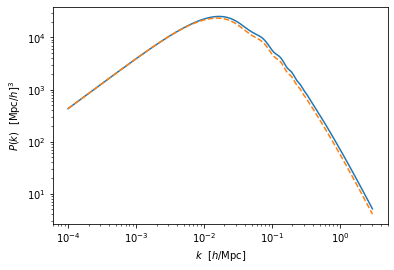

TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


TypeError: argument of type 'NoneType' is not iterable

Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable


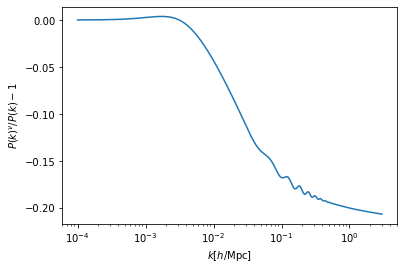

({'age': 13.772643180721698,
  'Neff': 2.937176973031231,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.25410592471491794,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.3098828062016554,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.6900631754903148,
  'Omega_m': 0.3098828062016554,
  'Omega_r': 5.4018308029658004e-05,
  'rs_drag': 148.4273434996185,
  'Sigma8': 0.7564493008790236,
  'Sigma8_cb': 0.7718341529074011,
  'T_cmb': 2.7255,
  'theta_s_100': 1.0503074986421015,
  'theta_star_100': 1.0527099475735826,
  'n_s': 0.9660499,
  'tau_reio': 0.05430842},
 {'age': 13.770676396299137,
  'Neff': 2.937176973031231,
  'omega_b': 0.022382800000000005,
  'Omega0_cdm': 0.26120569320189113,
  'h': 0.6781,
  'Omega0_k': 0.0,
  'Omega0_m': 0.30988304299999997,
  'Omega_b': 0.04867734979810887,
  'Omega_g': 5.378150968509927e-05,
  'Omega_lambda': 0.69002730029851,
  'Omega_m': 0.30988304299999997,
  'Omega_r': 8.965670148999979e-05,
  'rs_d

In [13]:
v_masses_therm(0.1,True,"nontherm_func",True)

In [14]:
def make_data(filename1,filename2,filename3,filename4,filename5,filename6,small_m1,small_m2,small_m3,filename):
    m1 = small_m1*10**-3
    m2 = small_m2*10**-3
    m3 = small_m3*10**-3
    
    n_result_nontherm,L_result_nontherm = v_masses_nontherm_alpha(m1,True,filename,False,filename1,False)
    n_result2_nontherm,L_result2_nontherm = v_masses_nontherm_alpha(m2,True,filename,False,filename2,False)
    n_result3_nontherm,L_result3_nontherm = v_masses_nontherm_alpha(m3,True,filename,False,filename3,False)
    
    n_result3_therm,L_result3_therm = v_masses_therm(m1,True,filename4,False)
    n_result3_therm,L_result3_therm = v_masses_therm(m2,True,filename5,False)
    n_result3_therm,L_result3_therm = v_masses_therm(m3,True,filename6,False)


In [15]:
def make_graphs(file1,file2,file3,file4,file5,file6):
    
    data_m1= np.load(file1)
    L_array_m1 = data_m1['LambdaCDM_array']
    Pkn_array_m1 = data_m1['Pk_n_array']
    k_array_m1 = data_m1['k_n_array']
    
    data_m2= np.load(file2)
    L_array_m2 = data_m2['LambdaCDM_array']
    Pkn_array_m2 = data_m2['Pk_n_array']
    k_array_m2 = data_m2['k_n_array']
    
    data_m3= np.load(file3)
    L_array_m3 = data_m3['LambdaCDM_array']
    Pkn_array_m3 = data_m3['Pk_n_array']
    k_array_m3 = data_m3['k_n_array']
    
    
    
    data_m4= np.load(file4)
    L_array_m4 = data_m4['Lambda_array']
    Pkn_array_m4 = data_m4['Pk_n_array']
    k_array_m4 = data_m4['k_n_array']
    
    data_m5= np.load(file5)
    L_array_m5 = data_m5['Lambda_array']
    Pkn_array_m5 = data_m5['Pk_n_array']
    k_array_m5 = data_m5['k_n_array']
    
    data_m6= np.load(file6)
    L_array_m6 = data_m6['Lambda_array']
    Pkn_array_m6 = data_m6['Pk_n_array']
    k_array_m6 = data_m6['k_n_array']
    
    

    plt.figure()
    plt.semilogx(k_array_m1,Pkn_array_m1/L_array_m1-1,color="red")
    plt.semilogx(k_array_m2,Pkn_array_m2/L_array_m2-1,color="purple")
    plt.semilogx(k_array_m3,Pkn_array_m3/L_array_m3-1,color="blue")
    plt.semilogx(k_array_m4,Pkn_array_m4/L_array_m4-1,linestyle='--',color="red")
    plt.semilogx(k_array_m5,Pkn_array_m5/L_array_m5-1,linestyle='--',color="purple")
    plt.semilogx(k_array_m6,Pkn_array_m6/L_array_m6-1,linestyle='--',color="blue")
    plt.ylabel(r'$P(k)^\nu/P(k)-1$')
    plt.show()
    

In [16]:
make_data("short1_non","short2_non","short3_non","short1_therm","short2_therm","short3_therm",1,10,100,"mass-300-life-0.030.npz")

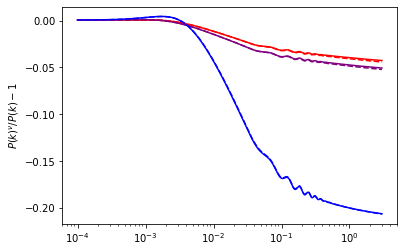

In [17]:
make_graphs("short1_non.npz","short2_non.npz","short3_non.npz","short1_therm.npz","short2_therm.npz","short3_therm.npz")

In [18]:
make_data("long1_non","long2_non","long3_non","long1_therm","long2_therm","long3_therm",1,10,100,"mass-300-life-0.584.npz")

Running CLASS version v3.2.0
Computing background
 -> age = 13.770598 Gyr
 -> conformal age = 14151.897990 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3405.751104
    corresponding to conformal time = 112.722902 Mpc
Running CLASS version v3.2.0
Computing background
 -> non-cold dark matter species with i=1 has m_i = 1.000000e-03 eV (so m_i / omega_i =8.173914e+01 eV)
 -> ncdm species i=1 sampled with 11 (resp. 5) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.00319
 -> non-cold dark matter species with i=2 has m_i = 8.717798e-03 eV (so m_i / omega_i =9.460773e+01 eV)
 -> ncdm species i=2 sampled with 11 (resp. 5) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.00319
 -> non-cold dark matter species with i=3 has m_i = 4.958831e-02 eV (so m_i / omega_i =9.483159e+01 e

 -> N_eff = 3.04683 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3404.456767
    corresponding to conformal time = 112.744322 Mpc
Running CLASS version v3.2.0
Computing background
 -> non-cold dark matter species with i=1 has m_i = 1.000000e-02 eV (so m_i / omega_i =1.921212e+02 eV)
 -> ncdm species i=1 sampled with 117 (resp. 58) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.01561
 -> non-cold dark matter species with i=2 has m_i = 1.322876e-02 eV (so m_i / omega_i =1.934464e+02 eV)
 -> ncdm species i=2 sampled with 117 (resp. 58) points for purpose of background (resp. perturbation) integration. In the relativistic limit it gives Delta N_eff = 1.01561
 -> non-cold dark matter species with i=3 has m_i = 5.057667e-02 eV (so m_i / omega_i =1.952390e+02 eV)
 -> ncdm species i=3 sampled with 117 (resp. 58) points for purpose of background (resp. perturbation)

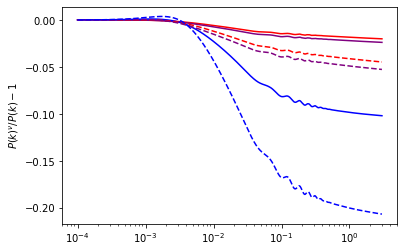

In [19]:
make_graphs("long1_non.npz","long2_non.npz","long3_non.npz","long1_therm.npz","long2_therm.npz","long3_therm.npz")